In [1869]:
# This is a notebook to analyse dataset for internet customers.

In [1870]:
# Local all required packages
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score, fbeta_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

In [1871]:
# Add function definitions
def radarplot(df, norm_max=False):
    df = df.copy()
    if norm_max:
        df /= df.max()

    angles = np.linspace(0, 2 * np.pi, len(df.columns), endpoint=False)
    angles = np.concatenate((angles, [angles[0]]))  # close the plot

    fig = plt.figure()
    ax = fig.add_subplot(111, polar=True)

    for i in df.index:
        stats = df.loc[i, :].values
        stats = np.concatenate((stats, [stats[0]]))  # close the plot
        ax.plot(angles, stats, 'o-', linewidth=2, label=i)
        ax.fill(angles, stats, alpha=0.25)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    columns = list(df.columns) + list(df.columns[:1])
    # print((angles * 180 / np.pi).shape, len(columns))
    ax.set_thetagrids(angles * 180 / np.pi, columns)
    ax.grid(True)
    return ax

In [1872]:
# Load the dataset
data = pd.read_csv("BP_DS_Challenge.csv")
data[:5]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [1873]:
# Dataset cleaning
data['TotalCharges'] = data['TotalCharges'].replace(" ", 0)
data['SeniorCitizen']= data['SeniorCitizen'].astype(str)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])
index = pd.Index(data['customerID'].to_list())
data = data.set_index('customerID')

In [1874]:
data[:5]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [1875]:
pd.concat([data.dtypes.to_frame().rename(columns={0: "type"}), data.nunique().to_frame().rename(columns={0: "unique_num"})], axis=1)

,type,unique_num
gender,object,2
SeniorCitizen,object,2
Partner,object,2
Dependents,object,2
tenure,int64,73
PhoneService,object,2
MultipleLines,object,3
InternetService,object,3
OnlineSecurity,object,3
OnlineBackup,object,3


In [1876]:
# Extract the independent variables and save as array in X
X = data.iloc[:,:-1].values
pd.DataFrame(X[:5])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.3,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.7,151.65


In [1877]:
# Extract the dependent variable and save as array in Y
Y = data.iloc[:,-1].values
pd.DataFrame(Y[:5])

,0
0,No
1,No
2,Yes
3,No
4,Yes


In [1878]:
data[:1]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No


In [1879]:
# Encode the two-value columns using LabelEncoding and the multi-value columns using one hot encoder
LE1 = LabelEncoder()
multi_value_categorical = []
for i in range(data.shape[1]-1):
    col_type = str(data.dtypes[i])
    col_name = str(data.columns[i])
    col_unique_values = str(data.nunique()[i])       
    print(str(i) + " " +col_type + " " + col_name + " " + col_unique_values)
    if col_type == 'object':
        if col_unique_values == '2':
            X[:,i] = np.array(LE1.fit_transform(X[:,i]))
        else:
            multi_value_categorical.append(i)
ct = ColumnTransformer(transformers=[('encoder',OneHotEncoder(), multi_value_categorical)],remainder="passthrough")
X = np.array(ct.fit_transform(X))
Y[:] = np.array(LE1.fit_transform(Y[:]))

0 object gender 2
1 object SeniorCitizen 2
2 object Partner 2
3 object Dependents 2
4 int64 tenure 73
5 object PhoneService 2
6 object MultipleLines 3
7 object InternetService 3
8 object OnlineSecurity 3
9 object OnlineBackup 3
10 object DeviceProtection 3
11 object TechSupport 3
12 object StreamingTV 3
13 object StreamingMovies 3
14 object Contract 3
15 object PaperlessBilling 2
16 object PaymentMethod 4
17 float64 MonthlyCharges 1585
18 float64 TotalCharges 6531


In [1880]:
pd.DataFrame(X[:5])

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0,0,1,0,1,0,1,29.85,29.85
1,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,1.0,1,0,0,0,34,1,0,56.95,1889.5
2,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,1,0,0,0,2,1,1,53.85,108.15
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1,0,0,0,45,0,0,42.3,1840.75
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0,0,0,0,2,1,1,70.7,151.65


In [1881]:
X_train,X_test,Y_train,Y_test = train_test_split(pd.DataFrame(X, index=index),pd.DataFrame(Y, index=index),test_size=0.2,random_state=0)
X_train_Index = X_train.index.values.tolist()
X_test_Index = X_test.index.values.tolist()
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
X_train = np.asarray(X_train).astype(np.float32)
Y_train = np.asarray(Y_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
Y_test = np.asarray(Y_test).astype(np.float32)

In [1882]:
# Normalise the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [1883]:
pd.DataFrame(X_train[:5])

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,1.035048,-0.326254,-0.852737,1.387528,-0.888655,-0.526281,-0.991516,-0.526281,1.574778,-0.880685,...,1.822238,-1.0,-0.439763,1.032476,-0.653215,1.612532,0.326254,-1.214659,0.674154,1.704761
1,-0.966139,3.065099,-0.852737,1.387528,-0.888655,-0.526281,1.008556,-0.526281,-0.635010,1.135479,...,-0.548776,-1.0,2.273954,-0.968546,-0.653215,-0.747907,-3.065099,0.823277,-0.614894,-0.709771
2,-0.966139,-0.326254,1.172694,-0.720706,-0.888655,1.900125,-0.991516,1.900125,-0.635010,-0.880685,...,-0.548776,-1.0,-0.439763,1.032476,1.530889,1.571835,0.326254,-1.214659,-1.335097,-0.208672
3,1.035048,-0.326254,-0.852737,1.387528,-0.888655,-0.526281,1.008556,-0.526281,-0.635010,1.135479,...,1.822238,1.0,-0.439763,1.032476,1.530889,0.025340,0.326254,0.823277,0.301578,0.053141
4,-0.966139,-0.326254,1.172694,-0.720706,1.125296,-0.526281,-0.991516,-0.526281,1.574778,-0.880685,...,-0.548776,-1.0,-0.439763,1.032476,-0.653215,0.595101,0.326254,0.823277,1.128231,0.990579


In [1884]:
ann = tf.keras.models.Sequential()

In [1885]:
ann.add(tf.keras.layers.Dense(units=50,activation="relu"))
ann.add(tf.keras.layers.Dense(units=1,activation="sigmoid"))

In [1886]:
optimizer = tf.keras.optimizers.SGD()

In [1887]:
ann.compile(optimizer, loss="mse", metrics=["mae", "acc"])

In [1888]:
history = ann.fit(X_train,Y_train,batch_size=32,epochs = 200)

Epoch 1/200
177/177 [==============================] - 1s 2ms/step - loss: 0.2320 - mae: 0.4459 - acc: 0.6221
Epoch 2/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1612 - mae: 0.3439 - acc: 0.7684
Epoch 3/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1516 - mae: 0.3183 - acc: 0.7796
Epoch 4/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1471 - mae: 0.3075 - acc: 0.7852
Epoch 5/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1444 - mae: 0.2993 - acc: 0.7893
Epoch 6/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1425 - mae: 0.2939 - acc: 0.7916
Epoch 7/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1411 - mae: 0.2904 - acc: 0.7938
Epoch 8/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1401 - mae: 0.2872 - acc: 0.7962
Epoch 9/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1393 - mae: 0.2853 - acc: 0.7964
Epoch 10/2

177/177 [==============================] - 0s 2ms/step - loss: 0.1301 - mae: 0.2641 - acc: 0.8151
Epoch 75/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1300 - mae: 0.2634 - acc: 0.8156
Epoch 76/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1300 - mae: 0.2638 - acc: 0.8135
Epoch 77/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1299 - mae: 0.2632 - acc: 0.8152
Epoch 78/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1299 - mae: 0.2630 - acc: 0.8163
Epoch 79/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1298 - mae: 0.2629 - acc: 0.8170
Epoch 80/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1298 - mae: 0.2630 - acc: 0.8161
Epoch 81/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1297 - mae: 0.2628 - acc: 0.8159
Epoch 82/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1297 - mae: 0.2627 - acc: 0.8161
Epoch 83/200
1

177/177 [==============================] - 0s 2ms/step - loss: 0.1271 - mae: 0.2567 - acc: 0.8211
Epoch 148/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1271 - mae: 0.2565 - acc: 0.8218
Epoch 149/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1271 - mae: 0.2572 - acc: 0.8211
Epoch 150/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1270 - mae: 0.2568 - acc: 0.8206
Epoch 151/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1270 - mae: 0.2568 - acc: 0.8211
Epoch 152/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1270 - mae: 0.2564 - acc: 0.8207
Epoch 153/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1269 - mae: 0.2566 - acc: 0.8206
Epoch 154/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1269 - mae: 0.2565 - acc: 0.8211
Epoch 155/200
177/177 [==============================] - 0s 2ms/step - loss: 0.1269 - mae: 0.2561 - acc: 0.8198
Epoch 

In [1889]:
lreg = LogisticRegression(random_state = 0)
lreg.fit(X_train, Y_train)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



LogisticRegression(random_state=0)

In [1890]:
ypred = {}
ypred["ANN"] = [x[0] for x in ann.predict(X_test)]
ypred["Regression"] = [x[1] for x in lreg.predict_proba(X_test)]

ANN
Regression


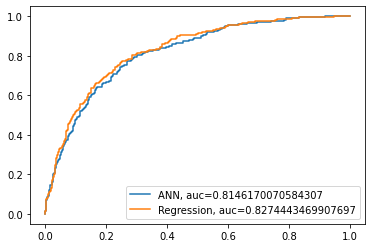

In [1891]:
results = {}
for method, predictions in ypred.items():
    print(method)
    fpr, tpr, _ = metrics.roc_curve(Y_test, predictions)
    auc = metrics.roc_auc_score(Y_test, predictions)
    plt.plot(fpr,tpr,label=method + ", auc="+str(auc))
    results[method] = [str(auc)]
plt.legend(loc=4)
plt.show()

In [1892]:
for method, predictions in ypred.items():
    preds = []
    for x in predictions:
        if x <= 0.5:
            preds.append(0.0)
        else:
            preds.append(1.0)
    acc = accuracy_score(Y_test, preds )
    prec = precision_score(Y_test, preds )
    rec = recall_score(Y_test, preds )
    f1 = f1_score(Y_test, preds )
    f2 = fbeta_score(Y_test, preds, beta=2.0)
    results[method] = np.concatenate((results[method], [acc, prec, rec, f1, f2]))

In [1893]:
results_df = pd.DataFrame(results, index=["auc", "acc", "prec", "rec", "f1", "f2"]).transpose()

In [1894]:
results_df = results_df.apply(pd.to_numeric)

In [1895]:
results_df

,auc,acc,prec,rec,f1,f2
ANN,0.814617,0.783534,0.594595,0.538043,0.564907,0.548476
Regression,0.827444,0.797019,0.631410,0.535326,0.579412,0.552130


<PolarAxesSubplot:>

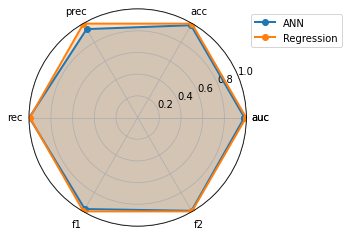

In [1896]:
# Visualise the offline evaluation results
radarplot(results_df, norm_max=True)

In [1897]:
without_promotion_revenue = 0
with_promotion = 0
for i, index in enumerate(X_test_Index):
    pred_churn = ypred["Regression"][i] <= 0.5
    true_churn = Y_test[i] == 1
    monthly_fee = data.loc[index][17]
    if true_churn == False:
        without_promotion_revenue += monthly_fee
    if true_churn == False and pred_churn == False:
        with_promotion += monthly_fee
    elif true_churn == True and pred_churn == True:
        with_promotion += monthly_fee*0.9
    elif true_churn == False and pred_churn == True:
        with_promotion += monthly_fee*0.9

In [1898]:
print(with_promotion, without_promotion_revenue)

68340.81500000005 63279.60000000004
